# 22.46 Procesamiento Adaptativo de Señales Aleatorias
# Proyecto 02
## Cancelación Activa de Ruido
Este trabajo desarrolla la síntesis de un sistema de cancelación activa de ruido basado en el algoritmo RLS, utilizando un enfoque donde sólo se busca modelar (de forma adaptativa) el camino acústico primario $P(z)$.

#### Grupo N° 1
* DAVIDOV, Gonzalo Joaquín
* FARALL, Facundo David
* KAMMANN, Lucas Agustín
* TROZZO, Rafael Nicolás

In [1]:
import importlib

In [2]:
import test_model
importlib.reload(test_model);

In [24]:
import anc_complete
importlib.reload(anc_complete);

In [178]:
import plot_helpers
importlib.reload(plot_helpers);

In [5]:
import boseqc20_model
importlib.reload(boseqc20_model);

In [14]:
import lms_complete
importlib.reload(lms_complete);

In [6]:
import numpy as np

In [103]:
from librosa import load

In [104]:
airport_noise = [np.array(load("../support/samples/airport.wav", sr=48e3)[0], dtype=float), "Airport"]
car_noise = [np.array(load("../support/samples/car.wav", sr=48e3)[0], dtype=float), "Car"]
exhibition_noise = [np.array(load("../support/samples/exhibition.wav", sr=48e3)[0], dtype=float), "Exhibition"]
restaurant_noise = [np.array(load("../support/samples/restaurant.wav", sr=48e3)[0], dtype=float), "Restaurant"]
street_noise = [np.array(load("../support/samples/street.wav", sr=48e3)[0], dtype=float), "Street"]
subway_noise = [np.array(load("../support/samples/subway.wav", sr=48e3)[0], dtype=float), "Subway"]
train_noise = [np.array(load("../support/samples/train.wav", sr=48e3)[0], dtype=float), "Train"]

## Variación de P y tiempos de convergencia
Para validar el funcionamiento y justificar el uso de un filtro LMS adaptativo, se prueba una situación más cercana a una aplicación real, donde P(z) cambia en el tiempo. En la siguiente prueba, en $t=5s$ se cambian los coeficientes de P entre la primera y la tercera medición de la base de datos y se observa la adaptación del filtro. Nota: Usé estas mediciones porque vi que cambiaban un poco, la primera y segunda eran bastante parecidas.

Primero con LMS

In [156]:
x = subway_noise[0][:48_000 * 5]
x /= x.max()

# Frequency responses change setup
# Measurement indexes to be used
indexes = [0, 2]
prim_paths = []
sec_paths = []

# Create the simulated headphone and the test noise
headphone = boseqc20_model.BoseQC20('../support/dataset/BoseQC20.json', secondary_enable=True, feedback_enable=True, room='acoustic_booth', order=2000)
headphone.set_noise(x)

In [157]:
# Algorithm parameters
order = 3000
step = 0.0005
w_lms = np.zeros(order)
error_lms = []
weights_lms = []

for index in indexes:
    # Set the primary path to see readaptation
    headphone.reset()
    headphone.set_measurement_index(index)
    
    # Save responses 
    prim_paths.append(headphone.p)
    sec_paths.append(headphone.g)

    # Run the algorithm
    aux_err, w_lms = lms_complete.anc_complete_system_nlms(headphone, headphone.g, headphone.f, order=order, step=step, initial_weights=w_lms)

    # Save weights and error
    weights_lms.append(np.array(w_lms))
    error_lms = np.concatenate([error_lms, aux_err])

Luego con RLS

In [150]:
x = subway_noise[0][:48_000 * 5]
x /= x.max()

# Frequency responses change setup
# Measurement indexes to be used
indexes = [0, 2]
prim_paths = []
sec_paths = []

# Create the simulated headphone and the test noise
headphone = boseqc20_model.BoseQC20('../support/dataset/BoseQC20.json', secondary_enable=True, feedback_enable=True, room='acoustic_booth', order=2000)
headphone.set_noise(x)

Se agregó una condición que ante el caso de que el error "explote" en RLS, se reinicia la matriz P con los valores de delta para acelerar su convergencia nuevamente.

In [151]:
# Algorithm parameters
forget = 0.02
order = 200
error_rls = []
weights_rls = []

for index in indexes:
    # Set the primary path to see readaptation
    headphone.reset()
    headphone.set_measurement_index(index)
    
    # Save responses 
    prim_paths.append(headphone.p)
    sec_paths.append(headphone.g)

    # Run the algorithm
    aux_err, w_rls = anc_complete.anc_complete(headphone, headphone.g, headphone.f, order=order, forget=forget, delta=np.var(x) * (1 - forget), force_hermitian=True)

    # Save weights_rls and error
    weights_rls.append(np.array(w_rls))
    error_rls = np.concatenate([error_rls, aux_err])

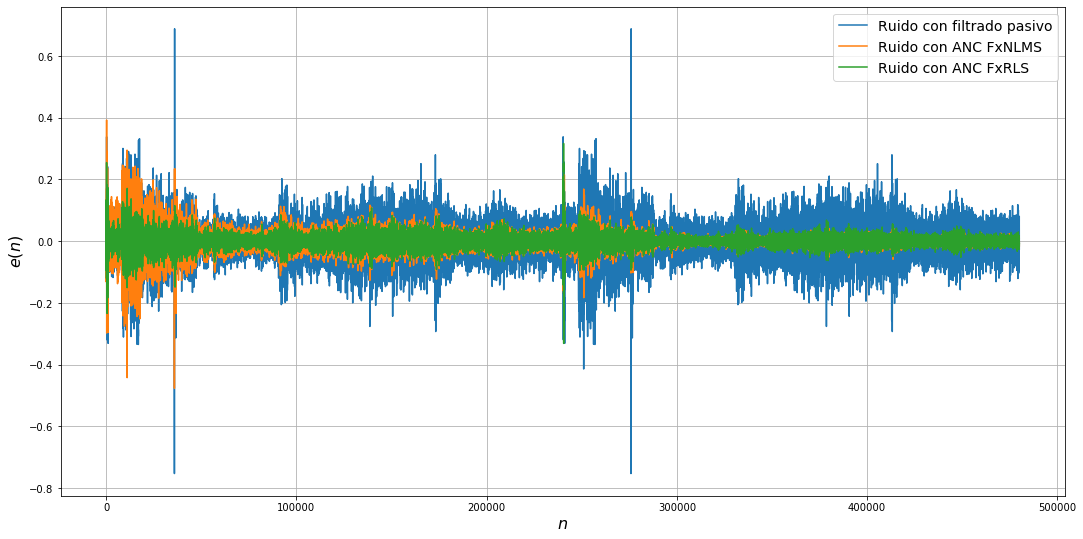

In [158]:
# Plot the ANC results
plot_helpers.plot_anc_results([np.concatenate([headphone.d,headphone.d]), error_lms, error_rls], labels=["Ruido con filtrado pasivo", "Ruido con ANC FxNLMS", "Ruido con ANC FxRLS"])

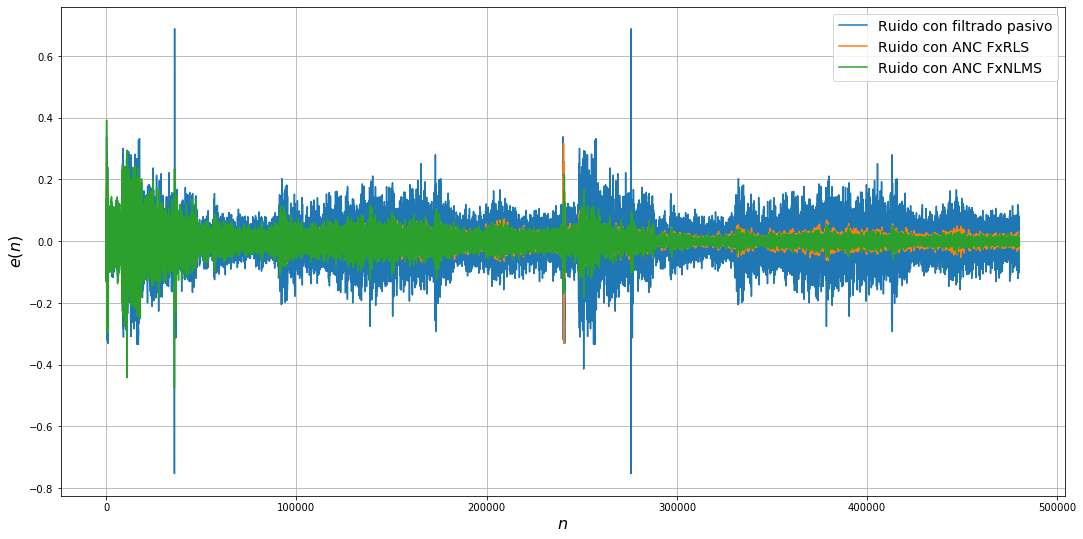

In [159]:
# Plot the ANC results
plot_helpers.plot_anc_results([np.concatenate([headphone.d,headphone.d]), error_rls, error_lms], labels=["Ruido con filtrado pasivo", "Ruido con ANC FxRLS", "Ruido con ANC FxNLMS"])

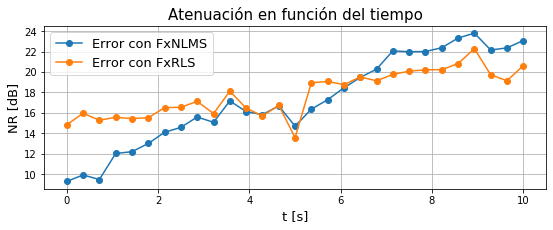

In [167]:
plot_helpers.plot_error_evolution(np.concatenate([x,x]), [error_lms, error_rls], 8192*2, 0, 48e3, labels=["Error con FxNLMS", "Error con FxRLS"])

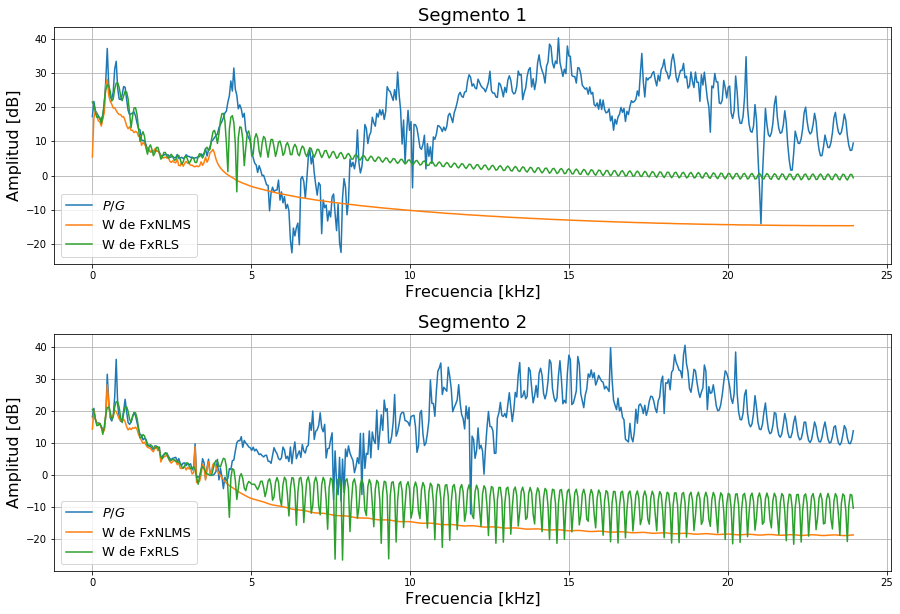

In [168]:
plot_helpers.plot_frequency_responses(prim_paths, sec_paths, [weights_lms, weights_rls], 48_000, labels=["W de FxNLMS", "W de FxRLS"])

## Tiempos de ejecución

In [169]:
import time

In [183]:
N = 1000

# Lists for elapsed times
lms_times = []
rls_times = []

for i in range(1, 11):
# Create the simulated headphone and the test noise
    headphone = boseqc20_model.BoseQC20('../support/dataset/BoseQC20.json', secondary_enable=True, feedback_enable=True, order=2000)
    x_white = np.random.normal(size=N * i)
    headphone.set_noise(x_white)

    # LMS parameters
    order = 3000
    step = 0.004
    w_lms = np.zeros(order)

    # Run LMS
    start_time = time.time()
    lms_complete.anc_complete_system_nlms(headphone, headphone.g, headphone.f, order=order, step=step, initial_weights=w_lms)
    lms_times.append(time.time() - start_time)

    headphone = boseqc20_model.BoseQC20('../support/dataset/BoseQC20.json', secondary_enable=True, feedback_enable=True, order=2000)
    x_white = np.random.normal(size=N * i)
    headphone.set_noise(x_white)
    
    # RLS parameters
    forget = 0.05
    order = 200

    # Run RLS
    start_time = time.time()
    anc_complete.anc_complete(headphone, headphone.g, headphone.f, order=order, forget=forget, delta=np.var(x_white) * (1 - forget), force_hermitian=True)
    rls_times.append(time.time() - start_time)

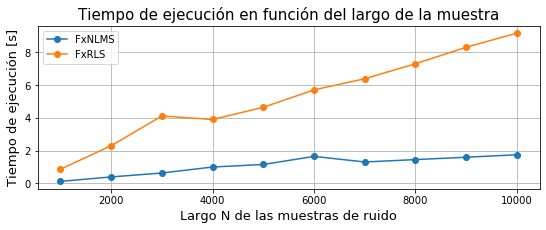

In [184]:
plot_helpers.plot_execution_times([lms_times, rls_times], N * np.array(range(1, 11)), ["FxNLMS", "FxRLS"])

In [186]:
print(f"El tiempo máximo de ejecución de FxNLMS es de {max(lms_times):.2f}s mientras que para FxRLS es de {max(rls_times):.2f}")

El tiempo máximo de ejecución de FxNLMS es de 1.75s mientras que para FxRLS es de 9.17
